# Unsupervised Learning


In this part, we will look at a few more unsupervised learning tasks and algorithms:

- Clustering: the goal is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.
- Anomaly detection: the objective is to learn what “normal” data looks like, and use this to detect abnormal instances, such as defective items on a production line or a new trend in a time series.
- Density estimation: this is the task of estimating the probability density function (PDF) of the random process that generated the dataset. This is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
#collapse-show
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import os
import sys

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from common.filesio import FilesIO
from common.figsio import save_fig

# Clustering

It is the task of identifying similar instances and assigning them to clusters, i.e., groups of similar instances.

## Introduction – Classification _vs_ Clustering

In [3]:
from sklearn.datasets import load_iris

In [4]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

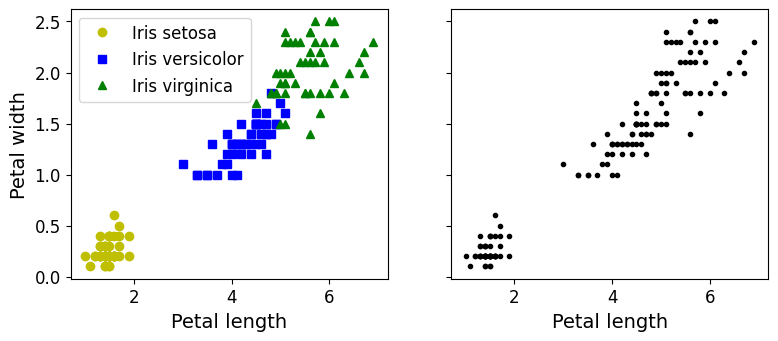

In [5]:
#collapse-show
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

# save_fig("classification_vs_clustering_plot")
plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [6]:
from sklearn.mixture import GaussianMixture

In [7]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

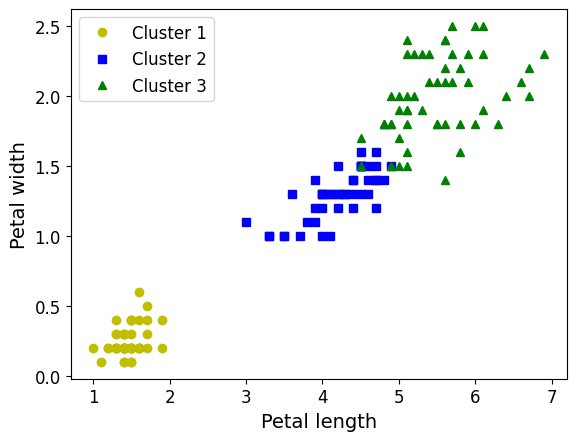

In [8]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [9]:
np.sum(y_pred==y)

145

In [10]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

Clustering is used in a wide variety of applications, including:
- For customer segmentation: you can cluster your customers based on their purchases, their activity on your website, and so on. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For example, this can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.
- For data analysis: when analyzing a new dataset, it is often useful to first discover clusters of similar instances, as it is often easier to analyze clusters separately.
- As a dimensionality reduction technique: once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k dimensional. This is typically much lower dimensional than the original feature vector, but it can preserve enough information for further processing.
- For anomaly detection (also called outlier detection): any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second, and so on. Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.
- For semi-supervised learning: if you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This can greatly increase the amount of labels available for a subsequent supervised learning algorithm, and thus improve its performance.
- For search engines: for example, some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database: similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is to find this image’s cluster using the trained clustering model, and you can then simply return all the images from this cluster.
- To segment an image: by clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to reduce the number of different colors in the image considerably. This technique is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

## K-Means

Let's start by generating some blobs:

In [11]:
from sklearn.datasets import make_blobs

In [12]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [13]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [14]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

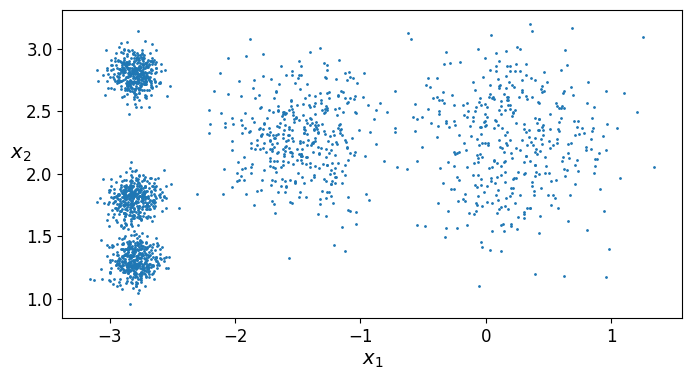

In [15]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
# save_fig("blobs_plot")
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [16]:
from sklearn.cluster import KMeans

In [17]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=11, n_init=10)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. 

Each instance was assigned to one of the 5 clusters:

In [18]:
y_pred

array([4, 0, 1, ..., 3, 1, 0])

In [19]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [20]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [21]:
kmeans.labels_

array([4, 0, 1, ..., 3, 1, 0])

Of course, we can predict the labels of new instances:

In [22]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 3, 3])

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [23]:
#collapse-show
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=30, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

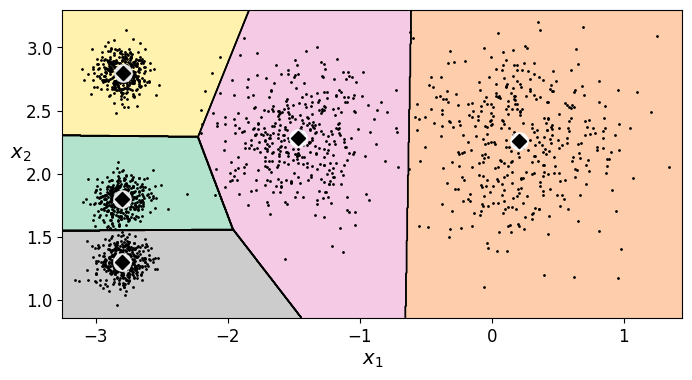

In [24]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
# save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [25]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 1.49439034, 2.9042344 , 2.88633901],
       [5.80730058, 2.80290755, 4.4759332 , 5.84739223, 5.84236351],
       [1.21475352, 3.29399768, 1.69136631, 0.29040966, 1.71086031],
       [0.72581411, 3.21806371, 1.54808703, 0.36159148, 1.21567622]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [26]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_,
                axis=2)

array([[2.81093633, 0.32995317, 1.49439034, 2.9042344 , 2.88633901],
       [5.80730058, 2.80290755, 4.4759332 , 5.84739223, 5.84236351],
       [1.21475352, 3.29399768, 1.69136631, 0.29040966, 1.71086031],
       [0.72581411, 3.21806371, 1.54808703, 0.36159148, 1.21567622]])

> If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this can be a very efficient non-linear dimensionality reduction technique.

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [27]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

And let's plot this:

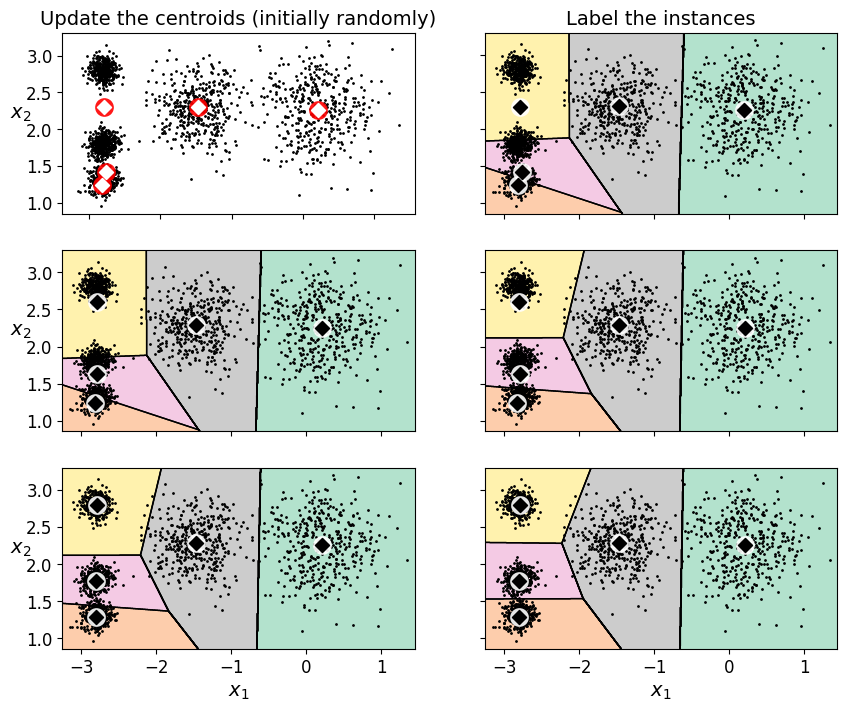

In [28]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

# save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [29]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

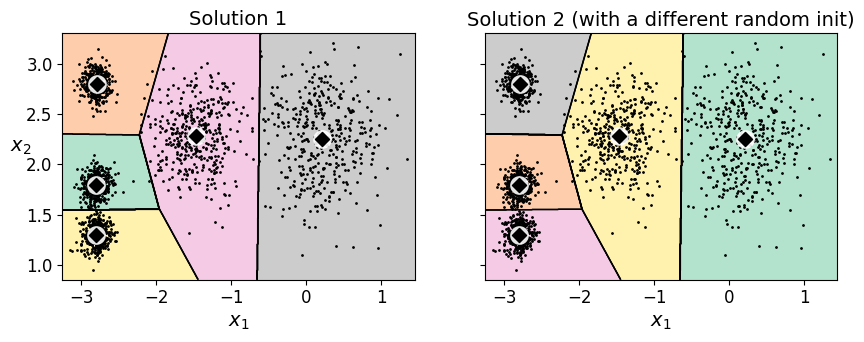

In [30]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=42)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

# save_fig("kmeans_variability_plot")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [31]:
kmeans.inertia_

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [32]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816862

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [33]:
kmeans.score(X)

-211.59853725816834

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [34]:
kmeans_rnd_init1.inertia_

211.59853725816836

In [35]:
kmeans_rnd_init2.inertia_

211.59853725816836

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [36]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, n_init=10,
       random_state=11)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

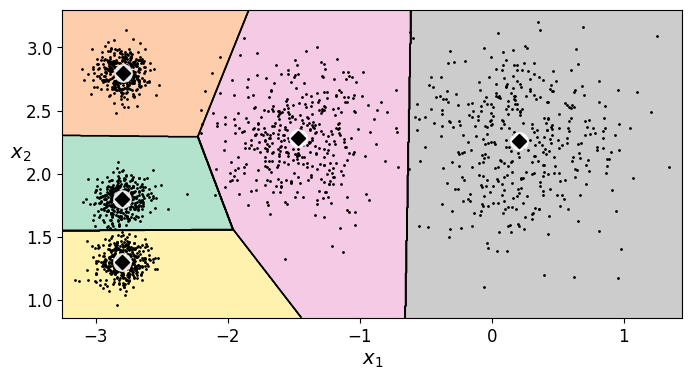

In [37]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [38]:
KMeans()

KMeans()

In [39]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, 
                n_init=1, random_state=42, algorithm="elkan")
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [40]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

53.4 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [41]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

27.6 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this is the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value.

What if the number of clusters was set to a lower or greater value than 5?

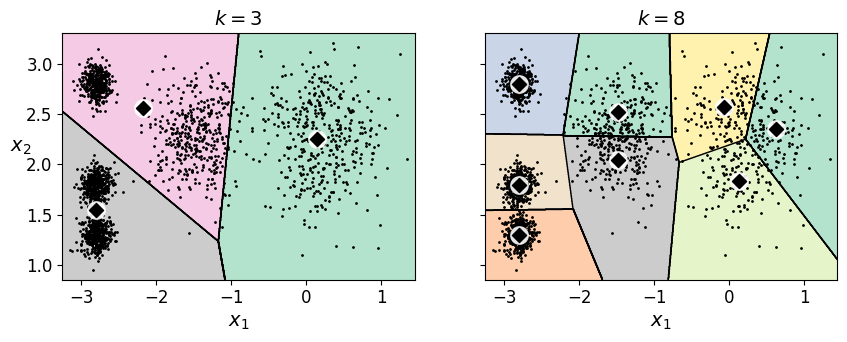

In [42]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
# save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [43]:
kmeans_k3.inertia_

653.2167190021552

In [44]:
kmeans_k8.inertia_

119.22484592677117

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [45]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

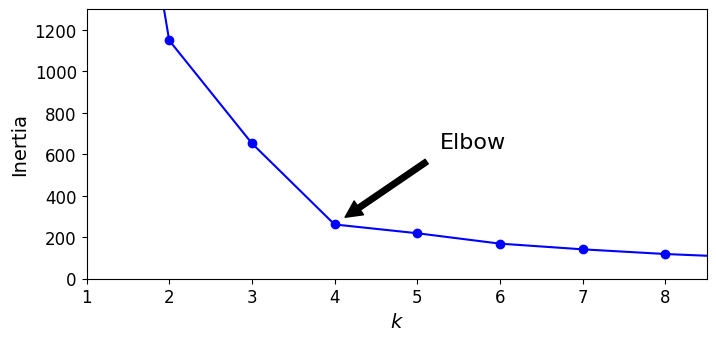

In [46]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
# save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

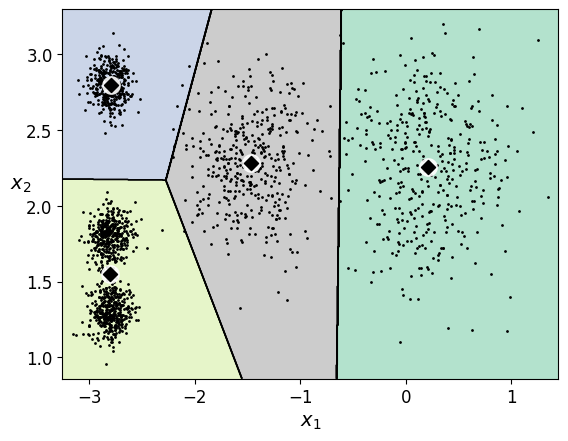

In [47]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [48]:
from sklearn.metrics import silhouette_score

In [49]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [50]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

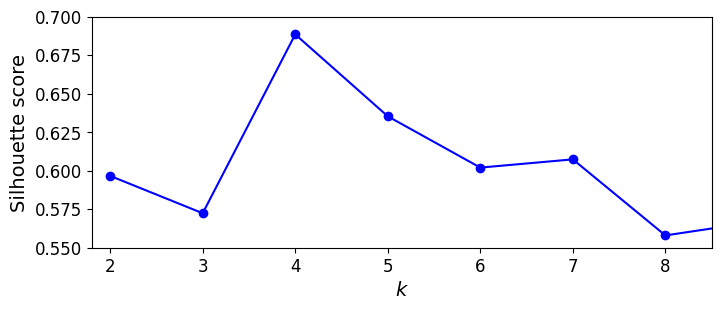

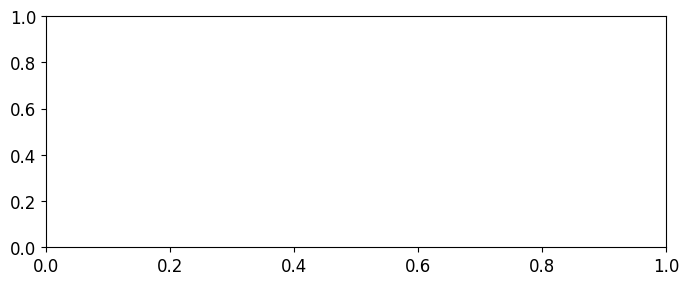

In [51]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()
fig, ax = plt.subplots(figsize=(8, 3))

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

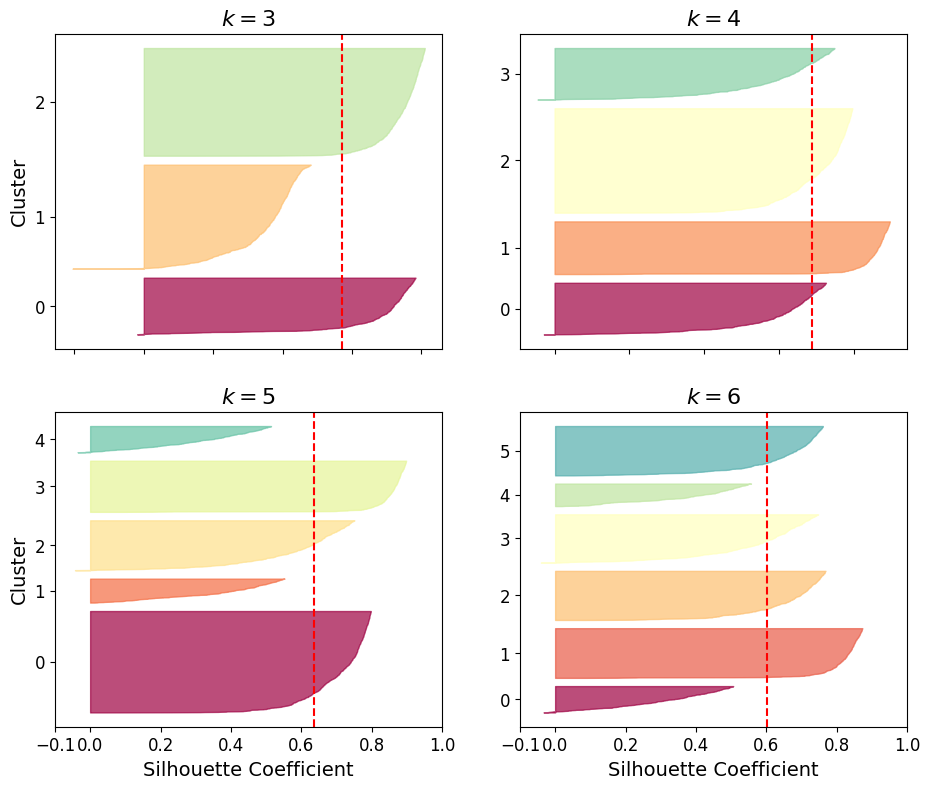

In [52]:
#collapse-show
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when k=3 and when k=6, we get bad clusters. But when k=4 or k=5, the clusters look pretty good – most instances extend beyond the dashed line, to the right and closer to 1.0. When k=4, the cluster at index 1 (the third from the top), is rather big, while when k=5, all clusters have similar sizes, so even though the overall silhouette score from k=4 is slightly greater than for k=5, it seems like a good idea to use k=5 to get clusters of similar sizes.

### Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid sub-optimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or non-spherical shapes.

In [53]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

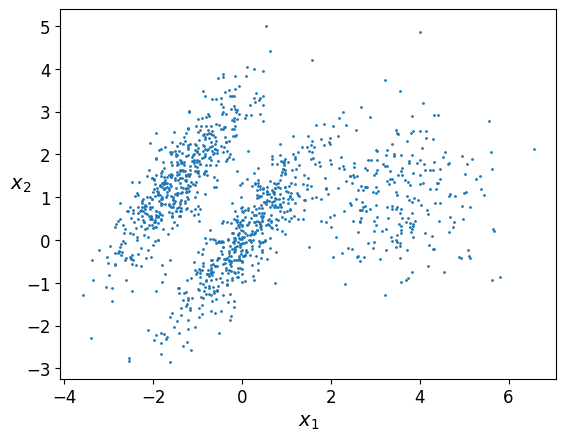

In [54]:
plot_clusters(X)

In [55]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

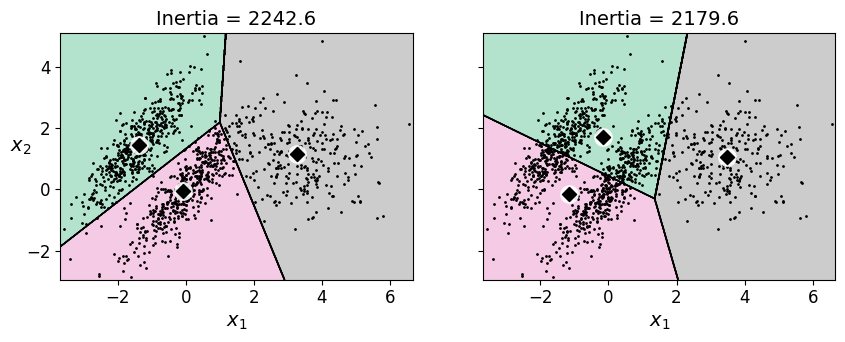

In [56]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

# save_fig("bad_kmeans_plot")
plt.show()

> It is important to scale the input features before you run K-Means, or else the clusters may be very stretched, and K-Means will per‐ form poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally improves things.


### Using clustering for image segmentation

Image segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. 

In [57]:
# Download the ladybug image
import urllib
image_path = "D:/GitsProject/FintechStudy/figures"
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(image_path, filename))

('D:/GitsProject/FintechStudy/figures\\ladybug.png',
 <http.client.HTTPMessage at 0x1e147368a30>)

In [58]:
from matplotlib.image import imread
images_path = "D:/GitsProject/FintechStudy/figures"
filename = "ladybug.png"
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [59]:
image

array([[[0.09803922, 0.11372549, 0.00784314],
        [0.09411765, 0.10980392, 0.00392157],
        [0.09411765, 0.11372549, 0.        ],
        ...,
        [0.22352941, 0.4117647 , 0.08235294],
        [0.21960784, 0.40392157, 0.08627451],
        [0.20392157, 0.3882353 , 0.07450981]],

       [[0.09411765, 0.10980392, 0.00392157],
        [0.09019608, 0.10588235, 0.        ],
        [0.09019608, 0.10588235, 0.        ],
        ...,
        [0.23529412, 0.42352942, 0.08627451],
        [0.23137255, 0.41568628, 0.09803922],
        [0.21568628, 0.4       , 0.08627451]],

       [[0.09019608, 0.10588235, 0.00784314],
        [0.08627451, 0.10196079, 0.00392157],
        [0.08627451, 0.10196079, 0.        ],
        ...,
        [0.25882354, 0.44705883, 0.10980392],
        [0.24705882, 0.43529412, 0.10588235],
        [0.22745098, 0.4117647 , 0.09411765]],

       ...,

       [[0.05490196, 0.07058824, 0.00392157],
        [0.05490196, 0.07058824, 0.00392157],
        [0.05098039, 0

In [60]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [61]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

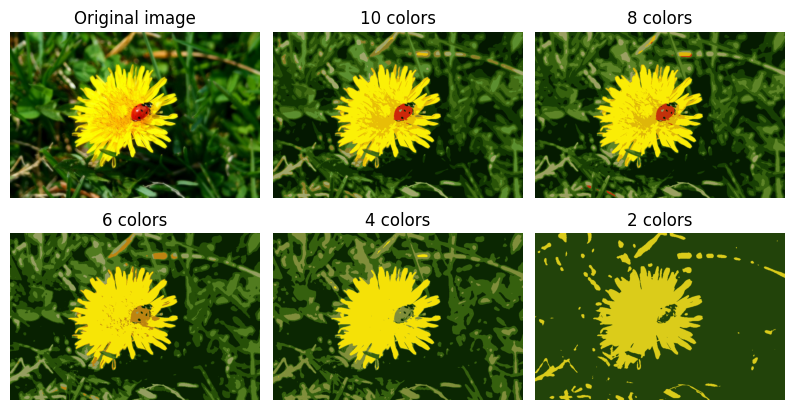

In [62]:
#collapse-show
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

# save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm.

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [63]:
from sklearn.datasets import load_digits

In [64]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
log_reg = LogisticRegression(
    multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42
)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [69]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [70]:
from sklearn.pipeline import Pipeline

In [71]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [72]:
pipeline.score(X_test, y_test)

0.9733333333333334

In [73]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [74]:
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid = dict(kmeans__n_clusters=range(2, 100, 10))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   3.1s
[CV] END ..............................kmeans__n_clusters=36; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=36; total time=   3.5s
[CV] END ..............................kmeans__n_clusters=36; total time=   3.2s
[CV] END ..............................kmeans__n_clusters=37; total time=   3.6s
[CV] END ..............................kmeans__n_clusters=37; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=38; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=38; total time=   3.5s
[CV] END ..............................kmeans__n_clusters=38; total time=   3.6s
[CV] END ..............................kmeans__n_clusters=39; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=39; total time=   3.7s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   4.0s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.4s
[CV] END ..............................kmeans__n_clusters=70; total time=   3.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=71; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=71; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=71; total time=   3.8s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=72; total time=   4.4s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.9s
[CV] END ..............................kmeans__n_clusters=73; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=73; total time=   4.0s
[CV] END ...................

/Users/xiahua/anaconda3/envs/py3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Let's see what the best number of clusters is:

In [32]:
grid_clf.best_params_

{'kmeans__n_clusters': 86}

In [33]:
grid_clf.score(X_test, y_test)

0.9822222222222222

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [75]:
n_labeled = 50

In [76]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [77]:
k = 50

In [78]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

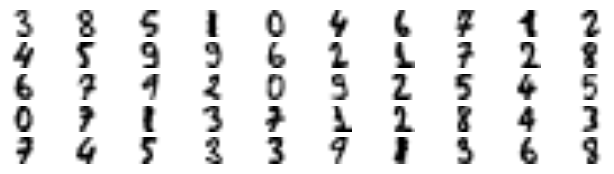

In [79]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

# save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [80]:
y_representative_digits = np.array([
    3, 8, 5, 1, 0, 4, 6, 7, 1, 2,
    4, 5, 9, 9, 6, 2, 1, 7, 2, 8,
    6, 7, 9, 2, 0, 9, 2, 5, 4, 5,
    0, 7, 1, 3, 7, 2, 2, 8, 4, 3,
    7, 4, 5, 3, 3, 9, 8, 9, 6, 8])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [81]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8866666666666667

Wow! We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [82]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [83]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [84]:
log_reg.score(X_test, y_test)

0.9111111111111111

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [85]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [86]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [87]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [89]:
log_reg.score(X_test, y_test)

0.8866666666666667

Nice! With just 50 labeled instances (just 5 examples per class on average!), we got 94% performance, which is pretty close to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [90]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9409722222222222

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## DBSCAN

This algorithm defines clusters as continuous regions of high density. It is actually quite simple:

- For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s ε- neighborhood.
- If an instance has at least min_samples instances in its ε-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.
- All instances in the neighborhood of a core instance belong to the same cluster. This may include other core instances, therefore a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions.

In [91]:
from sklearn.datasets import make_moons

In [92]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [93]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the labels_ instance variable:

In [94]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

Notice that some instances have a cluster index equal to -1: this means that they are considered as anomalies by the algorithm. The indices of the core instances are available in the core_sample_indices_ instance variable, and the core instances themselves are available in the components_ instance variable:

In [95]:
len(dbscan.core_sample_indices_)

808

In [96]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [97]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [98]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [99]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [100]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

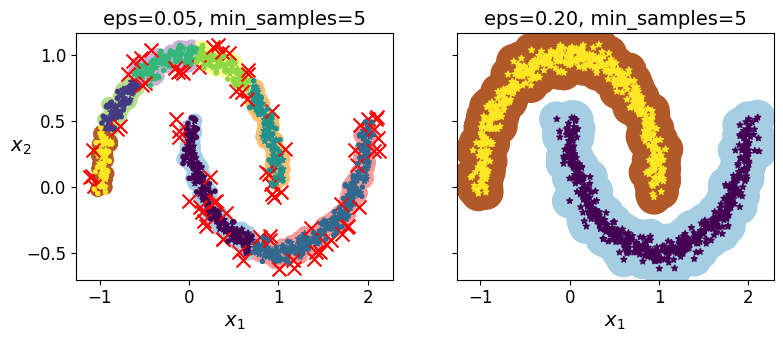

In [101]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

# save_fig("dbscan_plot")
plt.show()


In [102]:
dbscan = dbscan2

Somewhat surprisingly, the DBSCAN class does not have a predict() method, although it has a fit_predict() method. In other words, it cannot predict which cluster a new instance belongs to. The rationale for this decision is that several classification algorithms could make sense here, and it is easy enough to train one, for example a KNeighborsClassifier:

In [103]:
from sklearn.neighbors import KNeighborsClassifier

In [104]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong to, and even estimate a probability for each cluster. Note that we only trained them on the core instances, but we could also have chosen to train them on all the instances, or all but the anomalies: this choice depends on the final task.

In [105]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [106]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

The decision boundary is represented below (the crosses represent the 4 instances in X_new). Notice that since there is no anomaly in the KNN’s training set, the classifier always chooses a cluster, even when that cluster is far away. However, it is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, we can use the kneighbors() method of the KNeighborsClassifier: given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

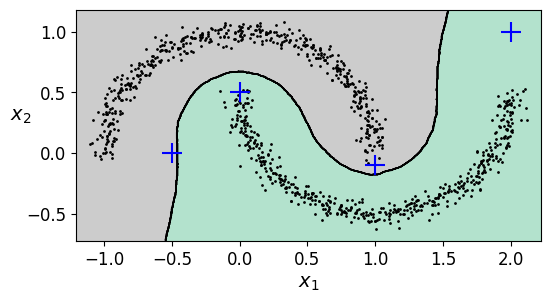

In [107]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
# save_fig("cluster_classification_plot")
plt.show()

In [108]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

# Gaussian Mixtures

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density and orientation

When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

#### Likelihood Function

Consider a one-dimensional mixture model of two Gaussian distributions centered at -4 and +1. For simplicity, this toy model has a single parameter θ that controls the standard deviations of both distributions. The top left contour plot shows the entire model f(x; θ) as a function of both x and θ. To estimate the probability distribution of a future outcome x, you need to set the model parameter θ. For example, if you set it to θ=1.3 (the horizontal line), you get the probability density function f(x; θ=1.3) shown in the lower left plot. Say you want to estimate the probability that x will fall between -2 and +2, you must calculate the integral of the PDF on this range (i.e., the surface of the shaded region). On the other hand, if you have observed a single instance x=2.5 (the vertical line in the upper left plot), you get the likelihood function noted L (θ|x=2.5)=f(x=2.5; θ) represented in the upper right plot.

In [109]:
from scipy.stats import norm

In [110]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

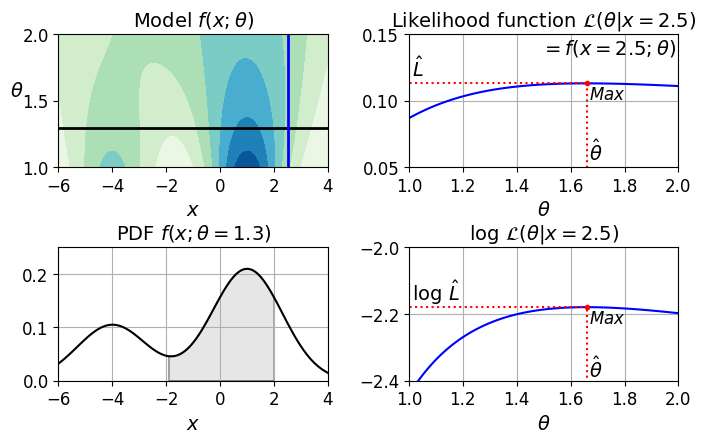

In [116]:
#collapse-show
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplots_adjust(wspace=0.3, hspace=0.6)
# save_fig("likelihood_function_plot")
plt.show()

# Expectation Maximization

In [117]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [118]:
from sklearn.mixture import GaussianMixture

In [119]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [121]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [120]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [122]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Did the algorithm actually converge?

In [123]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [124]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [125]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [126]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [127]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [128]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method. The greater the score, the higher the density:

In [130]:
gm.score_samples(X)

array([-2.60786904, -3.57094519, -3.3302143 , ..., -3.51359636,
       -4.39793229, -3.80725953])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [131]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999225081

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [132]:
#collapse-show
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

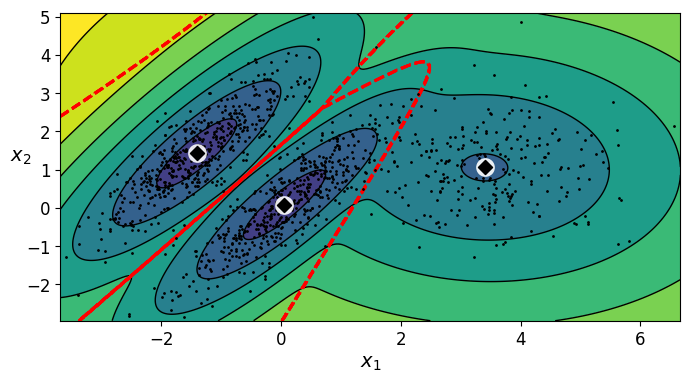

In [133]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

# save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [134]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [135]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


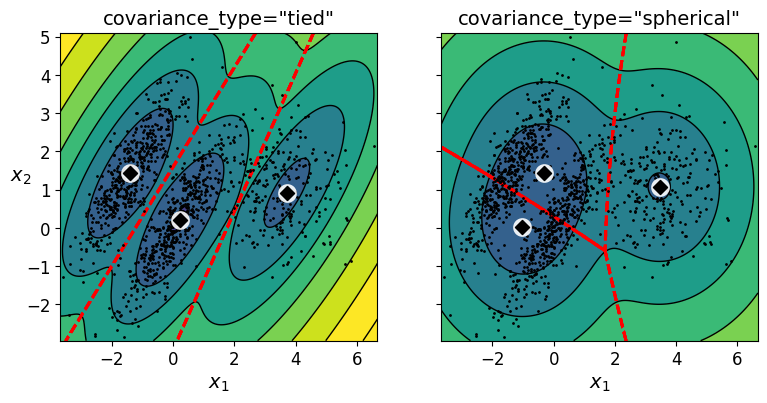

In [136]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

# save_fig("covariance_type_plot")
plt.show()

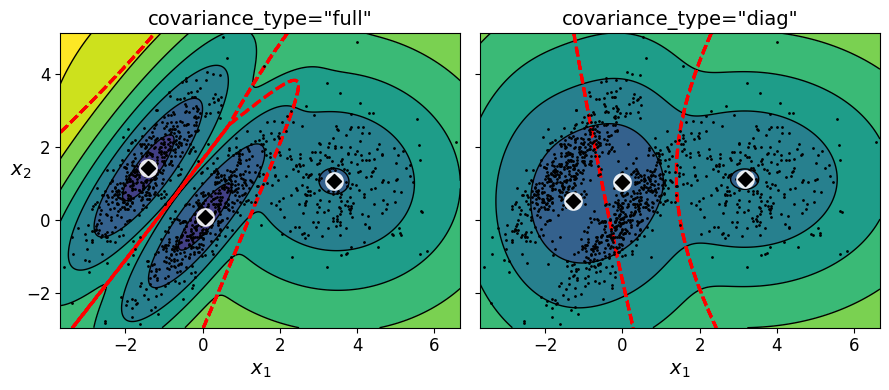

In [137]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection using Gaussian Mixtures

Anomaly detection (also called outlier detection) is the task of detecting instances that deviate strongly from the norm. These instances are of course called anomalies or outliers, while the normal instances are called inliers. Anomaly detection is very useful in a wide variety of applications, for example in fraud detection, or for detecting defective products in manufacturing, or to remove outliers from a dataset before training another model, which can significantly improve the performance of the resulting model.

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [138]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

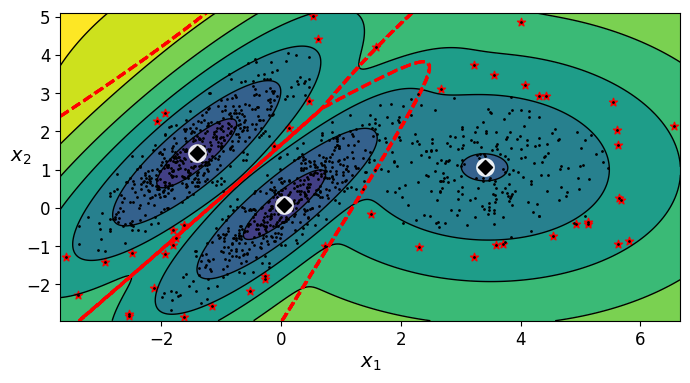

In [139]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

## Model selection

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [140]:
gm.bic(X)

8189.733705221636

In [141]:
gm.aic(X)

8102.508425106598

We could compute the BIC manually like this:

In [142]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [143]:
bic, aic

(8189.733705221636, 8102.508425106598)

In [144]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [145]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [146]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

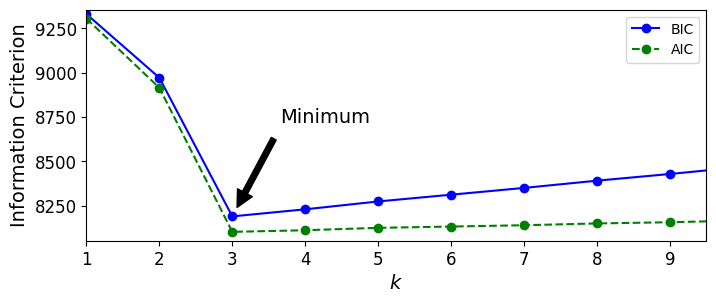

In [147]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
# save_fig("aic_bic_vs_k_plot")
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [148]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [149]:
best_k

3

In [150]:
best_covariance_type

'full'

## Variational Bayesian Gaussian Mixtures

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [151]:
from sklearn.mixture import BayesianGaussianMixture

In [152]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [153]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

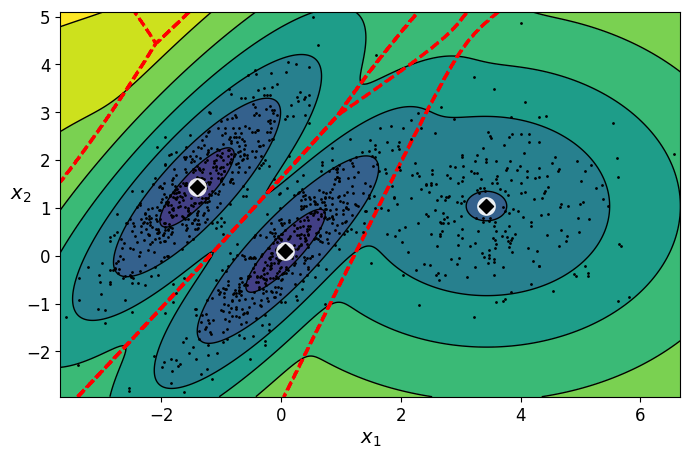

In [154]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [155]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [156]:
np.round(bgm_low.weights_, 2)

array([0.25, 0.26, 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [157]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.37, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


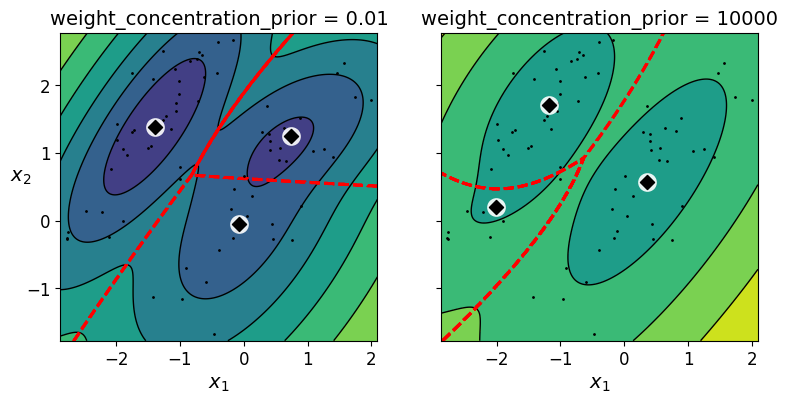

In [158]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Note: the fact that you see only 3 regions in the right plot although there are 4 centroids is not a bug. The weight of the top-right cluster is much larger than the weight of the lower-right cluster, so the probability that any given point in this region belongs to the top right cluster is greater than the probability that it belongs to the lower-right cluster.

In [159]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [160]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

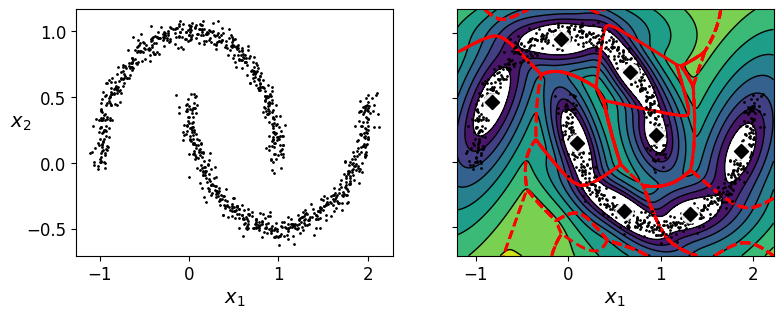

In [161]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

# save_fig("moons_vs_bgm_plot")
plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.